# Continuous Weighting Demo

Continuous weight balancing is done in three steps:
1. Approximate the source distribution
2. Select a target distribution
3. Determine transfer weights

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Approximate the source distribution
In this step, we approximate the distribution of the weight trait with an empirical density function. Our preferred approximation is just a kernel density estimate.

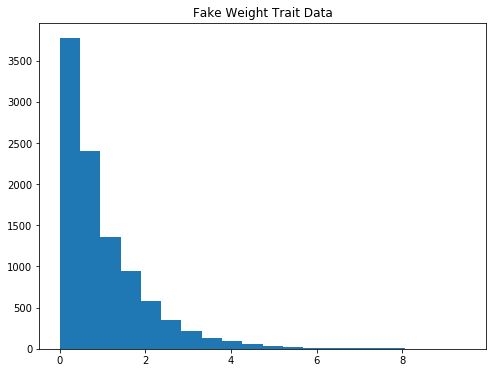

In [11]:
#Suppose we have some fake skewed weight trait data
trait = np.random.exponential(size = 10000)


plt.figure(figsize=(8, 6))
plt.title("Fake Weight Trait Data")
plt.hist(trait, bins=20)
plt.show()

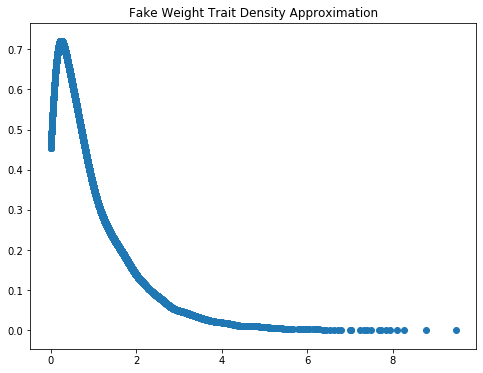

In [15]:
# We approximate this data with a KDE
source_kde = stats.gaussian_kde(trait)
estimate = source_kde.evaluate(trait)

plt.figure(figsize=(8, 6))
plt.title("Fake Weight Trait Density Approximation")
plt.scatter(trait, estimate)
plt.show()

## Step 2: Select a target distribution
In this step, we choose some target distribution of the data, as a function of the trait. Generally, this distribution is problem-specific. The crafted target density determines what domain of the trait the resultant model pays attention to. Some factors that go into this decision:
1. Does your problem formally specify some target distribution? Ex. reweighting a skewed dataset to match the population distribution of this weight trait. 
2. Can you make interesting statements about models trained with a certain distribution? Ex. reweighting financial models based on a volatility or market cap trait produces models with certain risk and size metrics.
3. Is there a domain of the weight trait that is particularly important? Ex. do values in a certain range usually constitute a decision boundary?

Our code works off-the-shelf with scipy.stats continuous distributions.

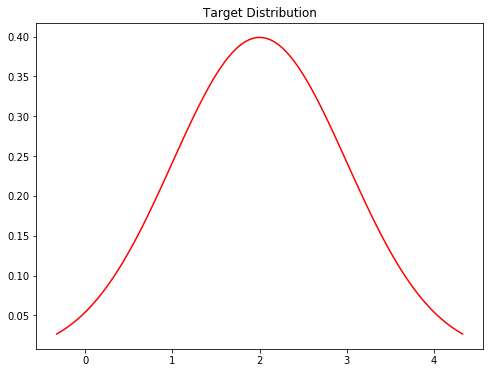

In [17]:
#Suppose we are interested in values around 2, and so we pick this distribution.
target = stats.norm(loc = 2, scale = 1)


plt.figure(figsize=(8, 6))
plt.title("Target Distribution")
x = np.linspace(target.ppf(0.01),
                target.ppf(0.99), 100)
plt.plot(x, target.pdf(x), "r")
plt.show()

## Step 3: Determine transfer weights
In this step, we find the weights to be applied to each data sample in order to get a trait distribution which matches our target. Our method is fairly straightforward - the weight is simply the ratio of the source density to the target density at each trait point. 

In formal terms, for a data point $x_i$ with weight trait $t_i$, the weight $w_i$ is given by:
$$
w_i = \frac{PDF_T(t_i)}{PDF_S(t_i)}
$$

where $PDF_T$ and $PDF_S$ are the probability density functions of the target and source distributions, respectively.

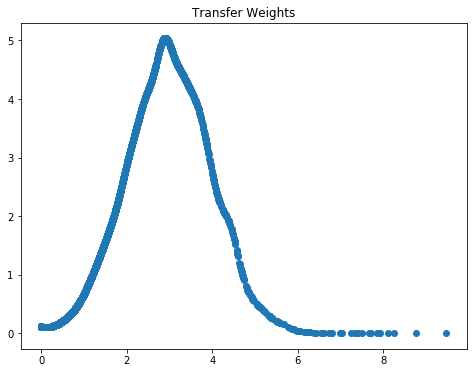

In [21]:
#Get weight ratio
weights = target.pdf(trait)/estimate


plt.figure(figsize=(8, 6))
plt.title("Transfer Weights")
plt.scatter(trait, weights)
plt.show()

Our rebalanced dataset now has the following weighted distribution, which closely matches our target distribution!

In [ ]:
weighted_kde = stats.gaussian_kde(trait, weights = weights)
weighted_estimate = weighted_kde.evaluate(trait)

plt.figure(figsize=(8, 6))
plt.title("Weighted Trait Distribution")
plt.scatter(trait, weighted_estimate)
plt.show()

## Bonus: weight analysis and postprocessing
With significant differences between the source and target distributions, your weights may be quite skewed.

(array([5935., 1148.,  697.,  503.,  366.,  254.,  258.,  236.,  321.,
         282.]),
 array([1.19110564e-09, 5.04075002e-01, 1.00815000e+00, 1.51222500e+00,
        2.01630000e+00, 2.52037500e+00, 3.02445000e+00, 3.52852500e+00,
        4.03260000e+00, 4.53667500e+00, 5.04075001e+00]),
 <a list of 10 Patch objects>)

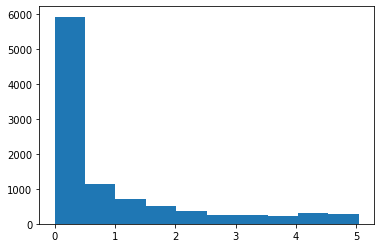

In [24]:
plt.hist(weights)

In [67]:
weights = weights.clip(0, 100)

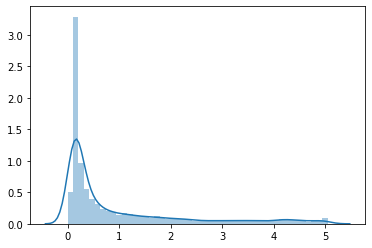

In [22]:
sns.distplot(weights)

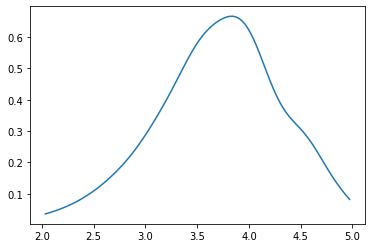

In [70]:
#Save the weights
np.save("../data/clipped/weight_train_richters_" + suffix + ".npy", weights)